In [10]:
import torch
import transformers
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import evaluate

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers.pipelines.pt_utils import KeyDataset
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from argparse import Namespace

In [2]:
config = {
    "cuda_device": 15,
    "path_to_model_on_disk": "/data3/mmendieta/models/xlmt_finetuned_twitter/", 
    "model_ckpt": "m2im/XLM-T_finetuned_violence_twitter",
    "max_length": 32,
    "dataset_name": "/data3/mmendieta/Violence_data/geo_corpus.0.0.1_tok_ds_xlmt_with_text",
    "batch_size": 64
}

args = Namespace(**config)

In [27]:
# Instantiate the pipeline with the model of choice
violence_pipe = pipeline(model=args.model_ckpt, 
                         device=args.cuda_device,
                         return_all_scores=True)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

In [4]:
# Recall that the test dataset has 2.329.158 observations. The inference is done in batches to exploit GPU resources
ds_tok = load_from_disk(args.dataset_name)

In [5]:
preds = []

for i, outputs in enumerate(tqdm(violence_pipe(KeyDataset(ds_tok['test'], "text"), batch_size=args.batch_size,
                                              truncation=True),
                                 total=len(ds_tok['test']))):
    preds.append(outputs)

  0%|          | 0/2329158 [00:00<?, ?it/s]

In [6]:
processed_data = []
for pred in preds:
    scores = {item['label']: item['score'] for item in pred}
    processed_data.append(scores)

In [7]:
# Convert to dataframe
df = pd.DataFrame(processed_data)
df

,post7geo10,post7geo30,post7geo50,pre7geo10,pre7geo30,pre7geo50
0,0.226729,0.327225,0.441367,0.219655,0.319141,0.428590
1,0.293337,0.432246,0.528523,0.447481,0.553608,0.688987
2,0.387055,0.544625,0.583162,0.392447,0.559619,0.588813
3,0.035168,0.038399,0.056211,0.041120,0.046594,0.070071
4,0.523534,0.921772,0.950220,0.902491,0.977367,0.988067
...,...,...,...,...,...,...
2329153,0.233221,0.262610,0.517162,0.212350,0.244978,0.467469
2329154,0.344274,0.470150,0.588610,0.358045,0.453263,0.578047
2329155,0.410559,0.470784,0.603613,0.320064,0.375958,0.494749
2329156,0.045838,0.062574,0.111670,0.047550,0.065505,0.121237


In [8]:
mean_preds = df.mean().to_frame(name='mean').T
mean_preds 

,post7geo10,post7geo30,post7geo50,pre7geo10,pre7geo30,pre7geo50
mean,0.345729,0.457622,0.576199,0.34781,0.445743,0.563775


In [9]:
mean_preds_th = (mean_preds >= 0.5).astype(int)
mean_preds_th

,post7geo10,post7geo30,post7geo50,pre7geo10,pre7geo30,pre7geo50
mean,0,0,1,0,0,1


### ROC-AUC score

In [12]:
# Calculate the predictions on the entire test dataset
preds = []
for i, outputs in enumerate(tqdm(violence_pipe(KeyDataset(ds_tok['test'], "text"), batch_size=args.batch_size,
                                              truncation=True),
                                 total=len(ds_tok['test']))):
    text = ds_tok['test'][i]['text']
    labels = ds_tok['test'][i]['labels']
    preds.append({
        'text': text,
        'labels': labels,
        'outputs': outputs
    })

  0%|          | 0/2329158 [00:00<?, ?it/s]

In [18]:
# Step 1: Calculate the ROC-AUC score
# Extract the ground truth labels and predicted probabilities for each label
# Convert `true_labels` to a 2D NumPy array if it's a list of tensors
true_labels = np.array([item['labels'] for item in preds])
true_labels = np.array([np.array(label) for label in true_labels])

# Convert prediction scores to a 2D array of floats
prediction_scores = np.array([
    [score['score'] for score in item['outputs']] for item in preds
])

/tmp/ipykernel_3013/894316054.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  true_labels = np.array([item['labels'] for item in preds])
/tmp/ipykernel_3013/894316054.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  true_labels = np.array([item['labels'] for item in preds])


In [ ]:
prediction_scores

In [21]:
# Initialize the Evaluate API for ROC-AUC
roc_auc = evaluate.load("roc_auc")

In [22]:
# Calculate ROC-AUC scores for each label

# Labels of interest
labels = ["post7geo10", "post7geo30", "post7geo50", "pre7geo10", "pre7geo30", "pre7geo50"]

roc_auc_scores = {}

for i, label_name in enumerate(labels):
    roc_auc_result = roc_auc.compute(
        prediction_scores=prediction_scores[:, i], 
        references=true_labels[:, i]
    )
    roc_auc_scores[label_name] = roc_auc_result['roc_auc']

In [23]:
# Calculate the average ROC_AUC across the six labels
average_roc_auc = sum(roc_auc_scores.values()) / len(roc_auc_scores)
print(f"Average ROC-AUC Score: {average_roc_auc:.2}")

Average ROC-AUC Score: 0.7


In [24]:
# Display individual ROC-AUC scores
for label, score in roc_auc_scores.items():
    print(f"ROC-AUC score for {label}: {score}")

ROC-AUC score for post7geo10: 0.715561457656639
ROC-AUC score for post7geo30: 0.713282200004705
ROC-AUC score for post7geo50: 0.6661996292860881
ROC-AUC score for pre7geo10: 0.72026636337389
ROC-AUC score for pre7geo30: 0.714432985612597
ROC-AUC score for pre7geo50: 0.6632925331743273


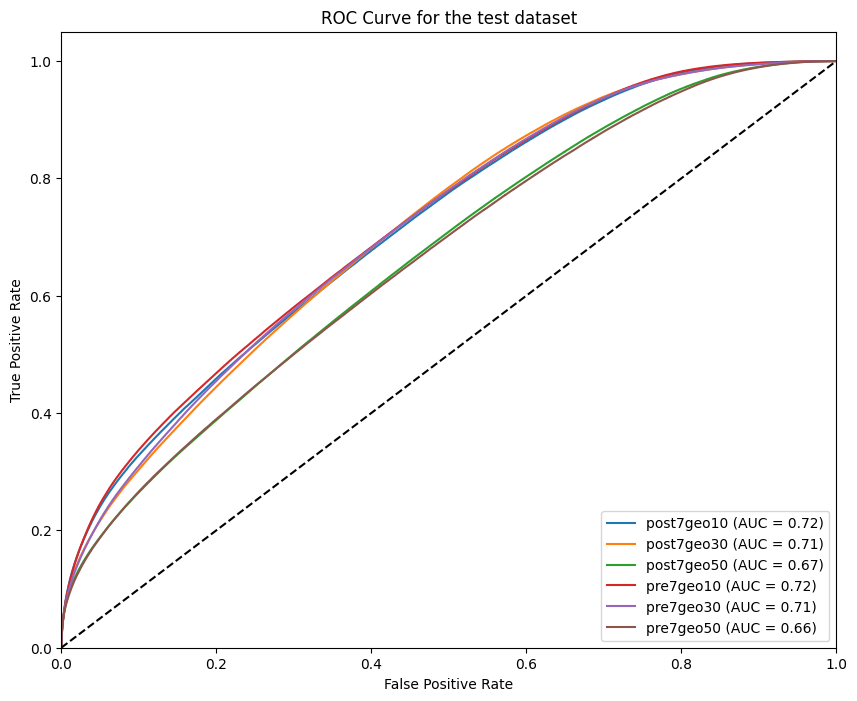

In [25]:
# Step 2: Plot the ROC curve for each label
plt.figure(figsize=(10, 8))

for i, label_name in enumerate(["post7geo10", "post7geo30", "post7geo50", "pre7geo10", "pre7geo30", "pre7geo50"]):
    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(true_labels[:, i], prediction_scores[:, i])
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{label_name} (AUC = {roc_auc_scores[label_name]:.2f})")

# Plot configuration
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the test dataset')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

In [37]:
# Save to disk
plt.savefig("/data3/mmendieta/Violence_data/case_studies/figs/ROC_test_set.eps", 
            format="eps", dpi=300,  bbox_inches="tight", transparent=True)